# Advanced: Emcee Initializing Distribution Requirements

**IMPORTANT**: this tutorial assumes basic knowledge (and uses a file resulting from) the [emcee tutorial](./emcee.ipynb).

**NOTE**: this behavior is new as of PHOEBE 2.4.

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [10]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

We'll now create a binary system, add dynamical RVs, and add an example initializing distribution and priors to use with emcee

In [3]:
b = phoebe.default_binary()
b.add_dataset('rv', compute_times=phoebe.linspace(0,1,11))
b.set_value_all('rv_method', 'dynamical')

b.add_distribution({'requiv@primary': phoebe.gaussian(1.5, 0.8),
                    'teff@primary': phoebe.gaussian(8000, 1000),
                    'ecc@binary': phoebe.gaussian(0, 0.2)},
                  distribution='myinit')

b.add_distribution('ecc@binary', phoebe.uniform(-0.5, 0.25), distribution='mypriors')

b.add_solver('sampler.emcee', init_from='myinit', priors='mypriors', solver='emcee_solver')

<ParameterSet: 16 parameters | qualifiers: niters, expose_failed, use_server, thin_factor, priors, init_from_combine, init_from_requires, nlags_factor, burnin_factor, comments, compute, progress_every_niters, nwalkers, priors_combine, continue_from, init_from>

## init_from_requires parameter

The emcee solver options include an `init_from_requires` parameter which by default is set to `['limits', 'priors']` but also has options for `'checks'` and `compute`.  

In [4]:
print(b.get_parameter(qualifier='init_from_requires', solver='emcee_solver'))

Parameter: init_from_requires@emcee_solver@solver
                       Qualifier: init_from_requires
                     Description: Requirements to apply to the initializing distribution.  Including all checks prevents walkers from initializing at lnprob=-inf, but does add overhead.  limits: apply parameter limits (cheap if init_from are univariates, otherwise requires testing samples).  priors: apply prior limits (directly if priors are uniform, otherwise from ppf at 1e-6 limits.  Cheap if init_from are univariates and priors do not contain OR logic, otherwise requires testing samples).  checks: test each sample to make sure it passes compute checks (and therefore includes limits).  compute: test each sample to make sure it successfully runs a forward model (and therefore includes checks and limits).
                           Value: ['limits', 'priors']
                         Choices: limits, checks, compute, priors
                  Constrained by: 
                      Cons

As explained in the parameter description, the choices will result in the following behavior:

* *limits*: parameter limits will be respected.  If `init_from` are univariates (no covariances) then this is done simply by apply a Uniform distribution via AND logic and is therefore quite cheap, computationally.  If `init_from` contains multivariate distributions, then each sample is instead tested against the parameter limits and redrawn if necessary, which can be slightly more expensive and therefore may be disabled if we are sure our `init_from` distributions are sufficiently within parameter limits.
* *priors*: prior limits will be respected.  For any distribution within `piors` that is a Uniform distribution, the limits are applied directly, otherwise the ppf at `1e-6` and `1-1e-6` are applied.  Similarly to 'limits', if `init_from` are univariates (and `priors` do not contain OR logic), then this is done cheaply by applying the respective Uniform distribution with AND logic.  Otherwise, each sample is tested and redrawn if resulting in a non-finite probability from the `priors` distribution(s).
* *checks*: [b.run_checks_compute](../api/phoebe.frontend.bundle.Bundle.run_checks_compute.md) must pass for each sample or it is redrawn.  If 'limits' is not used, this will effectively apply the requirement of parameter limits as well.  This can become expensive, especially if a lot of samples need to be redrawn.  This is most useful for cases where checks would catch an unphysical parameter combination that isn't easily covered by priors (roche overflow, for example).
* *compute*: [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) must successfully run for each sample or it is redrawn.  This will effecitively include both 'limits' and 'checks', whether they are selected or not.  This can become quite expensive, depending both on the number of redrawn samples and the cost of each forward model.  This is most useful for cases where checks cannot catch unphysical parameter combinations, including atmosphere out-of-bounds errors.

In most cases, the default is sufficient.  If you know that your system is near the edge of the parameter space or the emcee solution is showing walkers that are stuck at `lnprob=-inf`, then including additional requirements may be worth the extra cost.  

## Influence of init_from_requires on distributions

Within [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md), only `nwalkers` successful samples need to be drawn from the underlying distribution.  Here we'll show the influence of these options by calling [b.plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md) - which will draw and plot 10,000 samples if 'checks' and 'compute' are not required, otherwise 500 samples (by default) and will therefore take much longer than the typical overhead within emcee.

In [5]:
b.get_value(qualifier='init_from_requires')

['limits', 'priors']

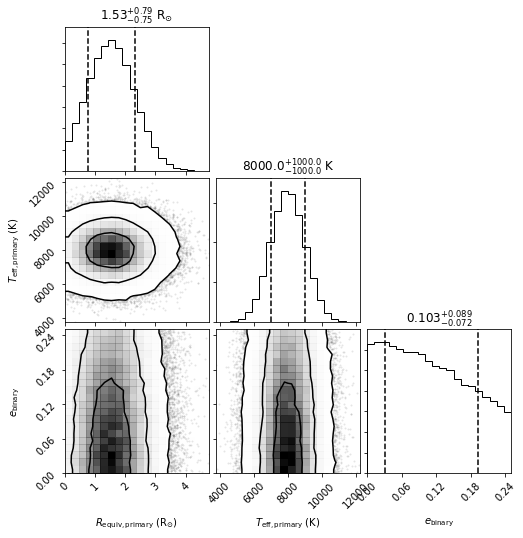

In [6]:
_ = b.plot_distribution_collection('init_from@emcee', show=True)

Here we can see that the `ecc` gaussian distribution has been truncated at 0 (because of parameter limits) and 0.25 (because of the uniform prior limits).

Now let's turn off prior limits to see only the parameter limits applied.

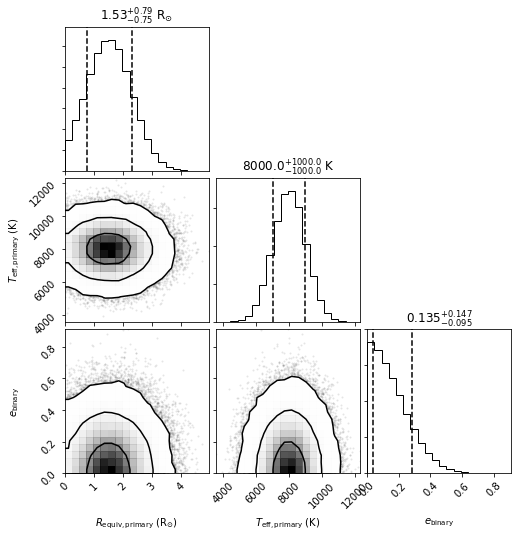

In [7]:
b.set_value(qualifier='init_from_requires', value=['limits'])
_ = b.plot_distribution_collection('init_from@emcee', show=True)

Or turn off all entirely to see the underyling distribution.

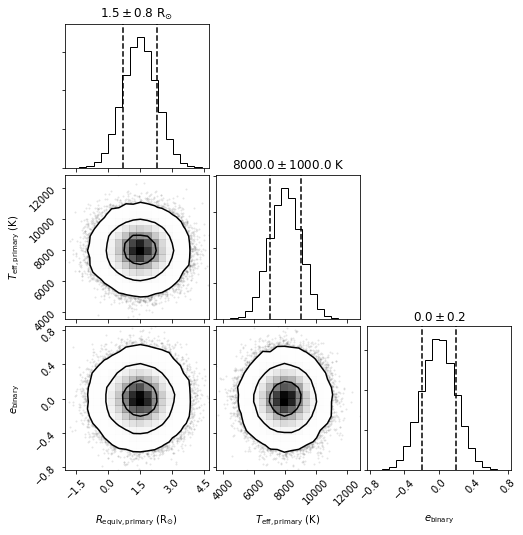

In [8]:
b.set_value(qualifier='init_from_requires', value=[])
_ = b.plot_distribution_collection('init_from@emcee', show=True)

Now we can add 'checks' and 'compute' in the mix by setting `init_from_requires` to '\*' (or all choices).  Here note that `plot_distribution_collection` will default to only 500 samples to save some time, and that we get a progressbar.  Because of this lower default sampling size, the resulting plot will look much "rougher" than those above.  If any sample is rejected 25 times, an error is raised.  Again, note that within emcee, the drawn sample size will generally be much smaller (`nwalkers`) so will add less overhead.

To change the number of sampled points when calling [b.plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md), pass `sample_size`.

100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


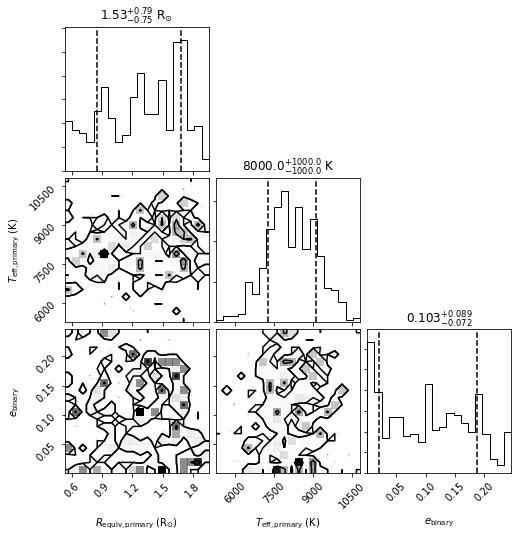

In [9]:
b['init_from_requires'] = '*'
_ = b.plot_distribution_collection('init_from@emcee', show=True)


## See Also

See the following for even more advanced use cases of emcee.

* [Advanced: EMCEE Initializing Distribution Requirements](./emcee_init_from_requires.ipynb)
* [Advanced: continue emcee from a previous run](./emcee_continue_from.ipynb)
* [Advanced: resampling EMCEE from a previous run](./emcee_resampling.ipynb)
* [Advanced: convert posterior distributions from EMCEE](./emcee_distributions_convert.ipynb)